# Data Generation Example
This notebook will cover how to use the `model.py` and `sample.py` scripts in this repository in order to generate data snapshots suitable for plotting or using in a learning framework. Assumptions and limitations of the model are discussed, and suggestions for best results are provided.

In [1]:
import sys, os
sys.path.append('../src')

import numpy as np
import yaml
import matplotlib
import matplotlib.pyplot as plt

import model
import sample

#plotting defaults
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.titlesize'] = 24
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['legend.fontsize'] = 16
matplotlib.rcParams['grid.color'] = 'k'
matplotlib.rcParams['grid.linestyle'] = ':'
matplotlib.rcParams['grid.linewidth'] = 0.5

## Define an Advective System
The `model` script should be used to simulate an advective system. There are many parameters that can be used to define an advective system, and for convenience a `.yaml` file can be used to define these characteristics. For this example, we will use `simple_flow.yaml` as the input to our simulator. Only the path to the file is necessary. 

In [2]:
simulator = model.Environment('../config/simple_flow.yaml')

Before we go further, let's inspect the contents of the yaml file:

In [3]:
with open('../config/simple_flow.yaml') as file:
    print yaml.dump(yaml.load(file))

Lx: 50
Ly: 50
T: 60
dt: 0.1
dx: 5
dy: 5
seed: 100
sources:
  source_1: {lx: 10, ly: 10, rate: 0.05, rx: 5, ry: 1}
  source_2: {lx: 40, ly: 40, rate: 0.01, rx: 1, ry: 5}
velocity:
  corrupt: false
  u_field:
    coeffs: [0.5]
    type: uniform
  v_field:
    coeffs: [0.0]
    type: uniform



The first set of parameters refers to the bounded region to be simulated: assuming that the bottom left corner is (0,0), then `Lx` is the x-axis length, and `Ly` is the y-axis length; both respectively discretized by `dx` and `dy`; `T` is the total simulation time to be run, discretized by `dt`; `seed` refers to a random seed to be used, so that results are repeatable if random noise or other processes are used in the simulation. `sources` refers to locations of constant flux (set by `rate`) in the environment, their locations are provided by `(lx, ly)`, and the size of their expression is provided as radius measures `(rx,ry)`. `velocity` defines the velocity field that dominates the advection; `corrupt` is a boolean that sets whether additive Gaussian noise should be used; and `u_field` and '`v_field` set the x and y direction velocities, respectively, `type` is an option of `[uniform, linear, quadratic, and periodic]` which defines a function that can be used to describe spatial or temporal variations in the velocity field, `coeffs` correspond to the type that is used; see the file for comments explaining.

The default initialization of any world is a uniform background without tracer. If a different initial condition is desired, there is a utility built in to the `Environment` class that must be used, which will be reviewed later.

For now, let's run this simulation and take a look at a few different ways to visualize the output.


In [4]:
history = simulator.simulate() #use the simulate method to run a Forward Euler Finite-Volume-Method calculation
X, Y = simulator.get_mesh() #helper function to get spatial mesh for plotting

('Now simulating time = ', 10.0, ' seconds')
('Now simulating time = ', 20.0, ' seconds')
('Now simulating time = ', 30.0, ' seconds')
('Now simulating time = ', 40.0, ' seconds')
('Now simulating time = ', 50.0, ' seconds')


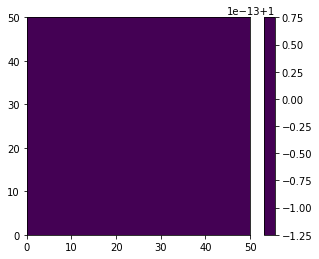

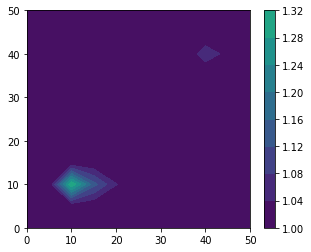

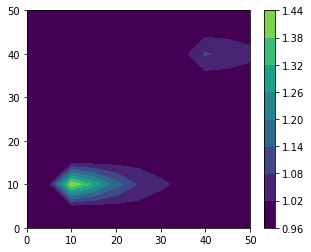

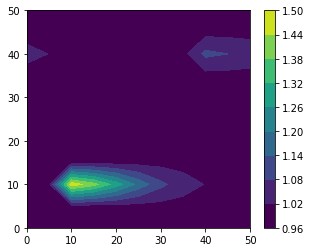

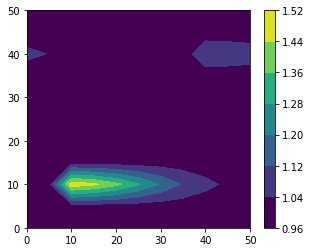

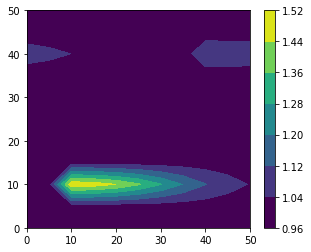

In [5]:
for t in range(0, history.shape[1]-1): #history is a matrix of environmental dimension x time dimension
    if t % 100 == 0:
        w, h = plt.figaspect(X)
        fig = plt.figure(figsize=(w+1, h))
        snapshot = history[:,t].reshape((simulator.NI, simulator.NJ))
        field = plt.contourf(X, Y, snapshot, vmin=np.nanmin(history), vmax=np.nanmax(history))
        plt.colorbar(field)
        plt.show()
        plt.close()

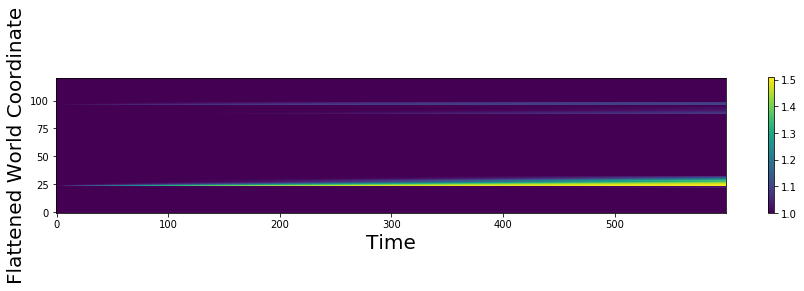

In [6]:
# the last method is rather tedius, another option is to use a Muller plot, which flattens the world
fig = plt.figure(figsize=(15,10))
hist = plt.imshow(history)
plt.colorbar(hist, shrink=0.25)
plt.xlabel('Time')
plt.ylabel('Flattened World Coordinate')
plt.gca().invert_yaxis()
plt.show()

Different parameters will lead to different patterns. It is recommended to play around with a few different options to see how everything propogates in time. **BUT NOTE** the method used to perform the simulation is very sensitive; for some parameter selections the method will appear to "break" -- the advection won't be smooth, or the numbers will look insane, or it will simply throw an error. There isn't necessarily a good way to set the best parameters for the system; there will always be some numerical loss and dissipation for most parameter selections. What's important is that this is known going in so that when parameter sweeps are designed, they will fall within valid ranges.

Now, let's say I want to resume a simulation from the last point in the history (this is useful if you'd like to run mini-batches of simulation data for a learning system, for example). Then I can use the method `apply_initial_condition` and pass in the state of the world that I would like to start from:



('Now simulating time = ', 10.0, ' seconds')
('Now simulating time = ', 20.0, ' seconds')
('Now simulating time = ', 30.0, ' seconds')
('Now simulating time = ', 40.0, ' seconds')
('Now simulating time = ', 50.0, ' seconds')


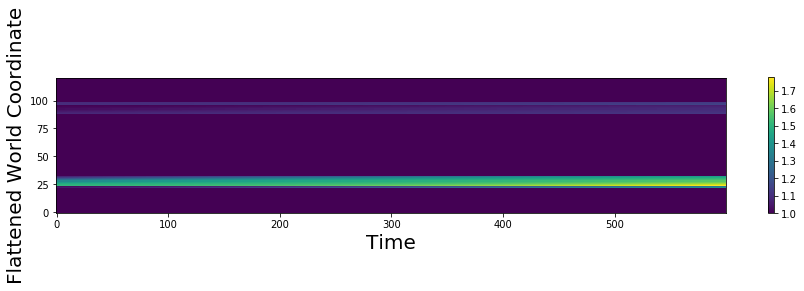

In [7]:
simulator.apply_initial_condition(simulator.world) #just using the last state of the world from the previous simulation
history = simulator.simulate() #now resimulate

fig = plt.figure(figsize=(15,10))
hist = plt.imshow(history)
plt.colorbar(hist, shrink=0.25)
plt.xlabel('Time')
plt.ylabel('Flattened World Coordinate')
plt.gca().invert_yaxis()
plt.show()

## Sample an Advective System
The `sample` script contains a Sampler class to help with data queries one might have about the history of data. Specifically, the sampler class will allow you to access time-specific "snapshots" of the environment (at your desired resolution), or query specific location and time points in the system. **PLEASE NOTE**: no time interpolation is done for queries; a queried time is matched with the closest time actually simulated; spatial interpolation is performed based on input parameters by the user.

Just like for the simulator, the sampler configuration is defined by a YAML file, in this case `simple_sampler.yaml`. Let's take a look:


In [8]:
with open('../config/simple_sampler.yaml') as file:
    print yaml.dump(yaml.load(file))

{Lx: 50, Ly: 50, T: 60, dt: 0.1, dx: 5, dy: 5, file: ../data/history.npz, interpolator: linear}



Environmental information is provided to the sampler; these *can* match what was used to simulate, or can be appropriately scaled versions of the parameters in case it is useful to change the scale of the simulation or units used in the simulation. A pointer to a history file (automatically saved by the environment simulator) is necessary to access the data, **the sampler does not perform any simulations**. The `interpolator` allows for the user to specify the type of spatial interpolation they want to use for their queries.

In [9]:
sampler = sample.Sampler('../config/simple_sampler.yaml')

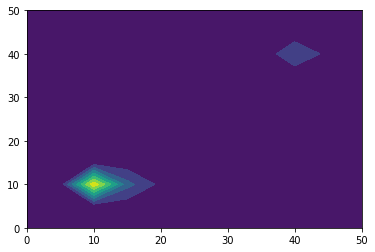

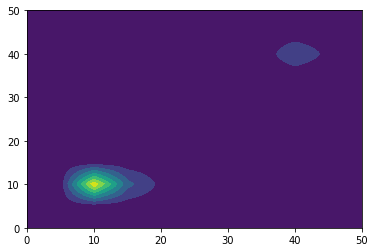

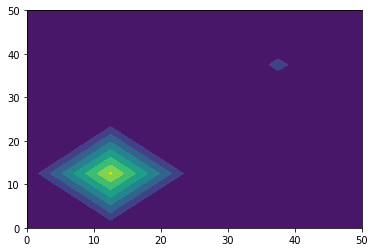

In [10]:
simple_snapshot = sampler.query_snapshot(time=10)

upsample_snapshot = sampler.query_snapshot(time=10, dimensions=(100,100))
upsamplex, upsampley = sampler.snapX, sampler.snapY

downsample_snapshot = sampler.query_snapshot(time=10, dimensions=(5,5))
downsamplex, downsampley = sampler.snapX, sampler.snapY

plt.contourf(sampler.X, sampler.Y, simple_snapshot)
plt.show()
plt.contourf(upsamplex, upsampley, upsample_snapshot)
plt.show()
plt.contourf(downsamplex, downsampley, downsample_snapshot)
plt.show()

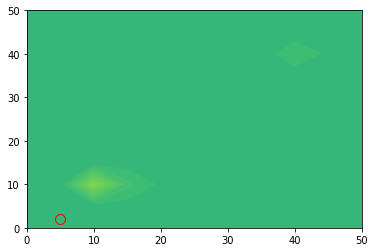

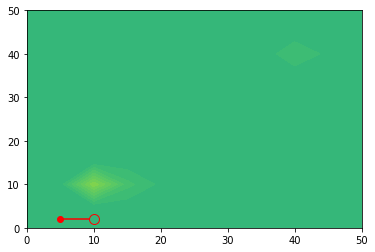

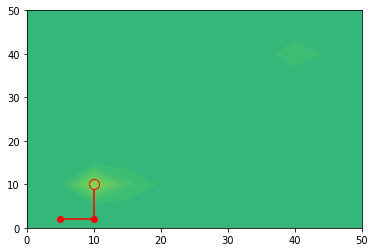

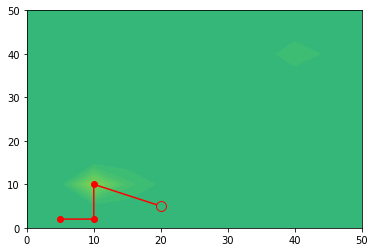

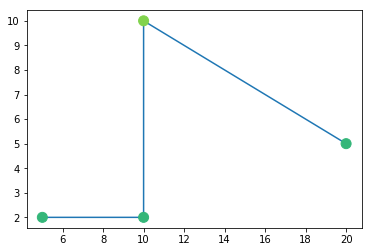

In [46]:
# and for a path, perhaps defined by a robot...
path = [(5, 2, 1),
        (10, 2, 2),
        (10, 10, 3),
        (20, 5, 4)]
coords = np.asarray(path)
observations = sampler.query_path(path)

# get the background for plotting
snapshots = []
for point in path:
    snapshots.append(sampler.query_snapshot(time=point[2]))

# plot observations on top of the query worlds
i = 0
for point, obs, snap in zip(path, observations, snapshots):
    plt.contourf(sampler.snapX, sampler.snapY, snap, vmin=np.nanmin(sampler.history), vmax=np.nanmax(sampler.history))
    plt.scatter(point[0], point[1], c=obs, vmin=np.nanmin(sampler.history), vmax=np.nanmax(sampler.history), edgecolor='red', s=100, zorder=2)
    plt.plot(coords[:i+1,0], coords[:i+1,1], zorder=1, color='red', marker='o')
    plt.show()
    i += 1

# plot observations on blank world
plt.scatter(coords[:,0], coords[:,1], s=100, c=observations, vmin=np.nanmin(sampler.history), vmax=np.nanmax(sampler.history), zorder=1)
plt.plot(coords[:,0], coords[:,1], zorder=0)
plt.show()